NB to show how to read STScI's precompiled background estimates for the ETC.  Want to make my own bathtub curves of zody vs time.  
To read binary files, following tutorial at http://vislab-ccom.unh.edu/~schwehr/rt/python-binary-files.html

In [138]:
# File description from email V Laidler 23 March 2017
# C structure used to write the stray light binary file.
# One record per file.
#    typedef struct {
#              double pix_ra;
#              double pix_dec;
#              double pos[3];
#              double nonzodi_bg[SL_NWAVE];  // The in-field ism+cib for each pixel.
#            } sl_pix;
#              Then for every day with the target in the FOR,the following three items are written.
#              double day;
#              double zodi_bg[SL_NWAVE];  //  The combined in-field zodi for each pixel.
#              double stray_light_bg[SL_NWAVE];  //The equivalent in-field background from stray light from zodi, stellar,ism, cib
#The wavelength array is the standard one that we converged
#on last year, so they are all on the same wavelength array
#that is SL_NWAVE = 108 elements long.

In [139]:
import struct
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [140]:
thedir = "/Volumes/Apps_and_Docs/MISSIONS/JWST/Zody_bathtubs/"  # Satchmo
thedir = "/Users/jrrigby1/MISSIONS/JWST/Zody_bathtubs/" # Milk
wave_file = "updated_std_spectrum_wavelengths.txt"  # Standard wavelength array.  Should be SL_NWave=108 long
wave_array = np.loadtxt(thedir + wave_file)
myfiles = ('sl_pix_000593.bin','sl_pix_041303.bin','sl_pix_099422.bin','sl_pix_157139.bin','sl_pix_196512.bin')
myfile = "bg_samples_for_jane/" + myfiles[2]
#myfile = "bg_samples_for_jane/sl_pix_099422.bin" #
SL_NWAVE = len(wave_array)  # should be 108.  Size of wavelength array
sbet_file = open(thedir + myfile)
sbet_data = sbet_file.read()

In [141]:
print "File has", len(sbet_data), "bytes, which is", len(sbet_data)/8., "doubles"
extra_junk = 183 # There are 183 extra doubles before the date-by-date that I cant explain
allval = struct.unpack(str(len(sbet_data)/8) + 'd', sbet_data)
#perday = 1 + SL_NWAVE*2  # size of a daily chunk
perday = SL_NWAVE*2  # size of a daily chunk
static = 5 + SL_NWAVE + extra_junk  # data for position, not time-variable
Ndays = (len(allval)*1.0 - static)/ perday   # if we subtract 2 here, get Ndays as int
print "Warning, Ndays should be an integer. Is it?", Ndays
Ndays = int(Ndays)
print len(allval)-1, "is last index of allval"
print " ", static, "values true for all dates, plus"
print " ", perday, "values per day for", Ndays, "days"
RA = allval[0]
DEC = allval[1]
pos = allval[2:5]
nonzodi_bg = allval[5:5+SL_NWAVE]
whatisthis = allval[5 + SL_NWAVE  : static]  # Ask Vicki, what is this extra stuff?
#print whatisthis

File has 195904 bytes, which is 24488.0 doubles
Warning, Ndays should be an integer. Is it? 112.0
24487 is last index of allval
  296 values true for all dates, plus
  216 values per day for 112 days


In [142]:
#day            = np.zeros(Ndays)
zodi_bg        = np.zeros((Ndays,SL_NWAVE))
stray_light_bg = np.zeros((Ndays,SL_NWAVE))
for dd in range(0, int(Ndays)):
    br1 = static +  dd*perday
    br2 = br1
    br3 = br2 + SL_NWAVE
    br4 = br3 + SL_NWAVE
    #print "Breaking at:", br1, br2, br3, br4, br2-br1, br3-br2, br4-br3
    #day[dd]               = allval[br1]  # Andrea pointed out there is no day here.
    zodi_bg[dd, ]        = allval[br2 : br3]
    stray_light_bg[dd, ] = allval[br3 : br4]
print br4, "was last double" 
#print "DEBUGGING", zodi_bg
#print "DEBUGGING", stray_light_bg

24488 was last double


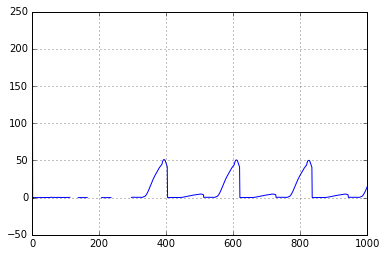

In [143]:
plt.plot(allval)
plt.xlim(0,1000)
#plt.ylim(0,30)
plt.grid()

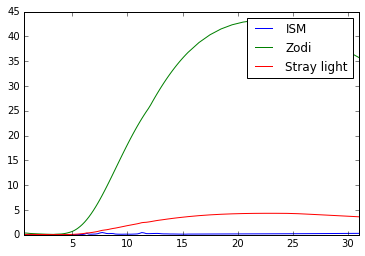

In [144]:
thisday = 100
plt.plot(wave_array, nonzodi_bg, label="ISM")
plt.plot(wave_array, zodi_bg[thisday, :], label="Zodi")
plt.plot(wave_array, stray_light_bg[thisday, :], label="Stray light")
plt.xlim(0.6,31)
plt.legend()

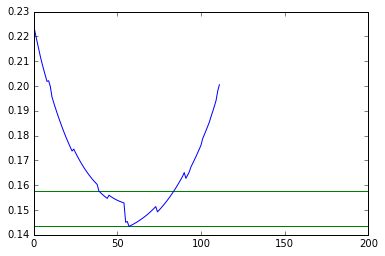

In [145]:
# Plot bathtub curve for 2um
twomicron = 16 # 2.0 micron is index 16 in wave_array
plt.plot( range(0,Ndays), zodi_bg[ : , twomicron])
themin = np.min(zodi_bg[ : , twomicron])
percentiles = (themin, themin*1.1)
plt.hlines(percentiles, 0, 200, color='green')